# Implementação de Métodos de Machine Learning
**Aluno:** Matheus Gama dos Santos - 20180163117<br>
**Curso:** Ciência da Computação - UFPB<br>
**Profª:** Thais Gaudencio do Rego<br><br>
Este projeto consiste na implementação de métodos de Machine Learning para analisar as bases de dados listadas abaixo:
- [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic/data)
- [
House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)
- [2018-2019 Premier League Data
](https://www.kaggle.com/thesiff/premierleague1819)

Cada base de dados será tratada em uma das 3 seções: **Classificação**, **Regressão** e **Clusterização** (nessa ordem).<br>

## Classificação

In [1]:
#install imblearn
!pip install imblearn

In [1]:
#import modules
import pandas as pd
import numpy as np
from sklearn import *
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.metrics import sensitivity_score, specificity_score
from string import ascii_letters
import ipywidgets as widgets

In [2]:
#load dataframe
titanic_filename = 'titanic/train.csv'
titanic_dataframe = pd.read_csv(titanic_filename)

In [4]:
titanic_dataframe.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Preprocessing

In [3]:
# select useful attributes
titanic_dataframe = titanic_dataframe.drop(["PassengerId", "Name", "Ticket", "Cabin", "Embarked", "Fare"], axis=1)
titanic_dataframe.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,male,22.0,1,0
1,1,1,female,38.0,1,0
2,1,3,female,26.0,0,0
3,1,1,female,35.0,1,0
4,0,3,male,35.0,0,0


In [4]:
# converting "Sex" attribute
titanic_dataframe.Sex = titanic_dataframe.Sex.replace({'male':0, 'female':1})
titanic_dataframe.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,0,22.0,1,0
1,1,1,1,38.0,1,0
2,1,3,1,26.0,0,0
3,1,1,1,35.0,1,0
4,0,3,0,35.0,0,0


In [5]:
titanic_dataframe.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000
mean,0.383838,2.308642,0.352413,29.699118,0.523008,0.381594
std,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000
50%,0.000000,3.000000,0.000000,28.000000,0.000000,0.000000
75%,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000


<font size="3">&emsp;&emsp;Analisando o estado atual do *Dataframe*, observa-se que o atributo *Age* possui mais de 100 linhas sem dado. Vamos realizar testes para verificar a influência das linhas com dado faltando.</font><br><br>

In [5]:
def get_titanic_survivability(d_frame_surv): # d_frame_surv: dataframe Survived column
    zeros = 0
    ones = 0
    for numbers in d_frame_surv:
        if numbers:
            ones += 1
        else:
            zeros += 1
    print(f"Died: {zeros} ({zeros/(zeros+ones)}), Survived: {ones} ({ones/(zeros+ones)})")

In [6]:
# Compare dataframe with and without missing data rows

# m_df will be titanic_dataframe.Survived without missing values
m_df = titanic_dataframe.dropna(axis=0)
m_df = np.array(m_df.Survived)

# dtf will be a copy of titanic_dataframe.Survived
df = np.array(titanic_dataframe.Survived)

In [10]:
# Compare results
print('Without missing values:')
get_titanic_survivability(m_df)
print('\nWith missing values:')
get_titanic_survivability(df)

Without missing values:
Died: 424 (0.5938375350140056), Survived: 290 (0.4061624649859944)

With missing values:
Died: 549 (0.6161616161616161), Survived: 342 (0.3838383838383838)


<font size="3">&emsp;&emsp;É possível observar que o balanceamento da base de dados, com relação ao *target* ( *Survived* ), não teve alteração significativa ao eliminar os objetos sem o valor do atributo *Age*. Vamos comparar, por fim, o impacto da mudança nos outros atributos.</font><br><br>

In [11]:
# description of titanic_dataframe
titanic_dataframe.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000
mean,0.383838,2.308642,0.352413,29.699118,0.523008,0.381594
std,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000
50%,0.000000,3.000000,0.000000,28.000000,0.000000,0.000000
75%,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000


In [12]:
# description of titanic_dataframe without the missing values
titanic_dataframe.dropna(axis=0).describe()

,Survived,Pclass,Sex,Age,SibSp,Parch
count,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000
mean,0.406162,2.236695,0.365546,29.699118,0.512605,0.431373
std,0.491460,0.838250,0.481921,14.526497,0.929783,0.853289
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,20.125000,0.000000,0.000000
50%,0.000000,2.000000,0.000000,28.000000,0.000000,0.000000
75%,1.000000,3.000000,1.000000,38.000000,1.000000,1.000000
max,1.000000,3.000000,1.000000,80.000000,5.000000,6.000000


<font size="3">&emsp;&emsp;O impacto não se mostrou significativo na distribuição dos outros atributos. Agora, vamos normalizar os dados e exibir a matriz de correlação dos atributos relevantes.</font><br><br>

In [7]:
titanic_dataframe = titanic_dataframe.dropna(axis=0)

# Normalizing dataframe
def normalize_df(df):
    d_values = df.values
    min_max_scaler = preprocessing.MinMaxScaler()
    d_values_scaled = min_max_scaler.fit_transform(d_values)
    df_norm = pd.DataFrame(d_values_scaled, columns=df.columns)
    return df_norm

titanic_dataframe_norm = normalize_df(titanic_dataframe)
titanic_dataframe_norm.sample(5)

,Survived,Pclass,Sex,Age,SibSp,Parch
295,1.0,0.0,0.0,0.308872,0.2,0.0
14,1.0,0.5,1.0,0.685851,0.0,0.0
544,0.0,1.0,0.0,0.233476,0.0,0.0
652,0.0,1.0,1.0,0.283740,0.0,0.0
413,0.0,1.0,0.0,0.396833,0.0,0.0


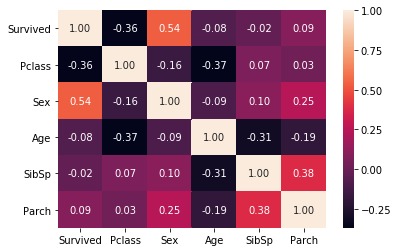

In [14]:
# Correlation Matrix
sns.heatmap(titanic_dataframe_norm.corr(), annot=True, fmt=".2f")
plt.show()

<font size="3">&emsp;&emsp;Em relação ao *target* (*Survived* ), é possível perceber que as correlações mais importantes são entre a classe do indivíduo ( -0,36 ) e o sexo ( 0,54 ). Quanto menor a classe social, mais chance de sobreviver. Também pode-se dizer que o sexo feminino tem mais chance de sobreviver do que o masculino. As outras correlações não apresentam valores expressivos. Analisaremos agora a presença de outliers em cada atributo.</font><br><br>

In [15]:
titanic_dataframe.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch
count,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000
mean,0.406162,2.236695,0.365546,29.699118,0.512605,0.431373
std,0.491460,0.838250,0.481921,14.526497,0.929783,0.853289
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,20.125000,0.000000,0.000000
50%,0.000000,2.000000,0.000000,28.000000,0.000000,0.000000
75%,1.000000,3.000000,1.000000,38.000000,1.000000,1.000000
max,1.000000,3.000000,1.000000,80.000000,5.000000,6.000000


<font size="3">&emsp;&emsp;*Survived* é um atributo binário, que também é o target, portanto seus valores tem significado classificatório. Logo, survived não possui outliers. Pclass também possui valores com significado classificatório (1, 2 ou 3), logo não possui outliers. Sex é binário e também possui significado classificatório, logo não possui outliers. Age, aparentemente possui outliers, dado que sua média tem valor aproximado de 29,6991, com desvio padrão de aproximadamente 14,5264. Se considerarmos ( $média + (2dp)$ ), valores acima de 58,7519 podem ser considerados outliers. Porém, nesse caso, a base de dados possui valores entre 58,7519 e 80, que são valores representativos pra base de dados. Além do mais, talvez se utilizássemos ( $média + (3dp)$ ) não consideraríamos como outlier. O mesmo acontece com SibSp e Parch. Para verificar as afirmações, vamos observar os gráficos de cada atributo.</font><br><br>

In [16]:
attribute = 'Survived'
def on_change(change):
    global attribute
    if change['type'] == 'change' and change['name'] == 'value':
        attribute = change['new']

In [17]:
w = widgets.Dropdown(
    options=[e for e in titanic_dataframe.columns],
    value=titanic_dataframe.columns[0],
    description='Attribute:',
    disabled=False,
)

w.observe(on_change)

display(w)

Dropdown(description='Attribute:', options=('Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch'), value='Surv…

##### Obs.: Selecione o atributo e execute as duas próximas células para exibir o histograma e boxplot

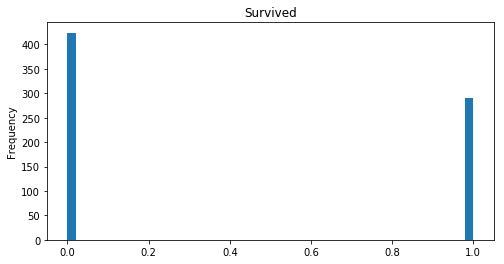

In [18]:
# Plot histogram
titanic_dataframe[attribute].plot(kind='hist',title=attribute ,bins=50,figsize=(8,4))

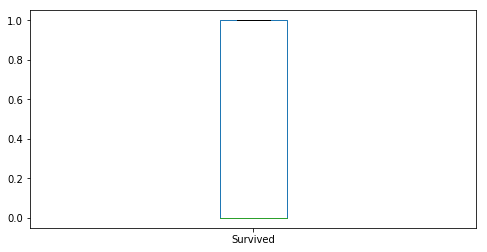

In [19]:
# Boxplot
titanic_dataframe[attribute].plot(kind='box',figsize=(8,4))

<font size="3">&emsp;&emsp;Ao observar os gráficos, vemos que SibSp e Parch são os atributos com verdadeiros outliers e não balanceados por essa mesma razão. Vamos retirar então os valores acima de ( $média + ( 3dp )$ ) dos dois atributos.</font><br><br>

In [20]:
# Dropping outliers
indexNames = titanic_dataframe[ (titanic_dataframe['SibSp'] > 3) | (titanic_dataframe['Parch'] > 3) ].index
titanic_dataframe.drop(indexNames , inplace=True)

# get normalized version
titanic_dataframe_norm = normalize_df(titanic_dataframe)

<font size="3">Agora temos os dados balanceados e normalizados, prontos para aplicar os modelos.</font><br><br>

### Models

In [21]:
# select features and target
y = titanic_dataframe_norm.Survived
x = titanic_dataframe_norm.drop(columns='Survived').to_numpy()

In [22]:
# split train and test
train_X, test_X, train_Y, test_Y = model_selection.train_test_split( x, y, random_state=0, test_size=.2 )

<font size="3">&emsp;&emsp;Os modelos escolhidos foram Random Forest e SVM, com a razão da escolha de cada um descrita junto com os resultados após a execução.</font><br><br>

In [23]:
# Random Forest
rdf = ensemble.RandomForestClassifier(n_estimators=100, max_depth=3, random_state=2)
rdf.fit(train_X, train_Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)

In [24]:
pred_Y = rdf.predict(test_X)
def show_metrics(test, pred):
    # accuracy: the fraction of predictions the model got right.
    accuracy = metrics.accuracy_score(test,pred)

    # sensitivy (recall): Percentage of correct predictions out of all the positive classes. (TP / TP+FN).
    sensitivity = sensitivity_score(test,pred)
    
    # specificity: proportion of actual negatives that are correctly identified as such. (TN / FP + TN).
    specificity = specificity_score(test,pred)
    
    """>Precision (used to calculate f1 score): Out of all the positive classes predicted correctly, how many are actually positive. (TP / TP+FP)"""
    # f1 score (harmonic mean of precision and recall): an accuracy coefficient with values between 0 and 1 (0 and 1 included).
    f1_score = metrics.f1_score(test, pred)

    x = np.array([accuracy, f1_score, sensitivity, specificity]).reshape(1,4)
    return pd.DataFrame(x, columns=["Accuracy", "F1 Score","Sensitivity", "Specificity"], index=["Results"])

results_r_forest = show_metrics(test_Y, pred_Y)
results_r_forest

,Accuracy,F1 Score,Sensitivity,Specificity
Results,0.861314,0.828829,0.793103,0.911392


In [25]:
# confusion matrix
def show_confusion_mat(test,pred):
    c_mat = metrics.confusion_matrix(test, pred)
    return pd.DataFrame(c_mat, columns=["P", "N"], index=["P", "N"])
mat_r_forest = show_confusion_mat(test_Y,pred_Y)
mat_r_forest

# TP  FP
# FN  TN

,P,N
P,72,7
N,12,46


<font size="3">&emsp;&emsp;Random Forest é um algoritmo de classificação e regressão, baseado em árvores de decisão, porém seu funcionamento corrige o hábito de realizar *overfitting* sobre a base de treinamento. Com acurácia de 0,861314 e F1-Score de 0,828829, o modelo se mostrou bem eficiente. Utilizando *max_depth* = 3, *random_state* = 2, obteve-se sensibilidade de 0,793103 e especificidade de 0,911392, que podem ser considerados bons resultados. Os valores para os parâmetros utilizados foram obtidos através de testes manuais e comparação.</font><br><br>

In [26]:
# SVC (SVM)
SVC = svm.SVC(gamma=11)
SVC.fit(train_X, train_Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=11, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [27]:
pred_Y = SVC.predict(test_X)
results_SVC = show_metrics(test_Y, pred_Y)
results_SVC

,Accuracy,F1 Score,Sensitivity,Specificity
Results,0.854015,0.821429,0.793103,0.898734


In [28]:
mat_SVC = show_confusion_mat(test_Y,pred_Y)
mat_SVC

,P,N
P,71,8
N,12,46


<font size="3">&emsp;&emsp;SVM é classificador linear binário não probabilístico que tenta definir uma reta que melhor separa as classes do problema. O fato da razão entre as saídas ser próximo de 1 e os objetos da base só possuírem apenas duas classificações possíveis são a justificativa para a escolha desse algoritmo. Os resultados foram bem satisfatórios, com acurácia de 0,854015 e F1-Score de 0,821429. Os números de acertos positivos e negativos também encontrou altas taxas, com sensibilidade de 0,793103 e especificidade de 0,898734. Foram testados alguns valores para o parâmetro *gamma*, que foi o mais impactante nos resultados quando alterado, dentro do intervalo de 1 a 15, com melhor valor sendo *gamma* = 11. A mudança do gamma para outros valores ocasiona em troca de acurácia e especificidade por sensibilidade, ou apenas a perda em algum dos valores. O estado atual mantém sensibilidade e especificidade balanceados, diminuindo a chance de *overfitting*.</font><br><br>

## Regressão

In [29]:
#load dataframes
hp_filename = 'house_prices/train.csv'
hp_dataframe = pd.read_csv(hp_filename, na_values=None,keep_default_na=False)

In [30]:
hp_dataframe.describe()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,10516.828082,6.099315,5.575342,1971.267808,1984.865753,443.639726,46.549315,567.240411,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,9981.264932,1.382997,1.112799,30.202904,20.645407,456.098091,161.319273,441.866955,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,223.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,383.500000,0.000000,477.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,712.250000,0.000000,808.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,5644.000000,1474.000000,2336.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### Preprocessing

In [31]:
# converting non-numerical attributes
file = open('house_prices/dict.txt','r')
replaces = file.read()
replaces = replaces.split(";")
for each_element in replaces:
    attribute = each_element[2:each_element.find("'",2)]
    dictionary = each_element[each_element.find("{",2) +1: each_element.find("}")].split(', ')
    dict_rep = {}
    for each_n_element in dictionary:
        value = each_n_element[each_n_element.find(": ")+2:]
        dict_rep[each_n_element[1:each_n_element.find("'",2)]] = int(value)
    hp_dataframe[attribute].replace(dict_rep, inplace=True)
file.close()
hp_dataframe[hp_dataframe.select_dtypes("object").columns] = hp_dataframe[hp_dataframe.select_dtypes("object").columns].astype('int', inplace=True)

In [32]:
# normalizing dataframe
hp_dataframe = normalize_df(hp_dataframe)
hp_dataframe.drop(columns=['Id'], inplace=True)
hp_dataframe.sample(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
627,0.352941,0.0,0.255591,0.038795,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.181818,1.00,0.000,0.0,0.164005
689,0.588235,0.0,0.194888,0.029339,0.0,0.0,0.333333,0.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.454545,0.25,0.000,0.0,0.221914
22,0.000000,0.0,0.239617,0.039459,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.727273,0.50,0.000,0.0,0.270935
1102,0.000000,0.0,0.223642,0.026642,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.272727,0.25,0.000,1.0,0.139008
1241,0.000000,0.0,0.265176,0.039959,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.454545,0.25,0.125,0.4,0.296387


### Models

In [33]:
# select features and target
y = hp_dataframe.SalePrice
x = hp_dataframe.drop(columns='SalePrice').to_numpy()
# split train and test
train_X, test_X, train_Y, test_Y = model_selection.train_test_split( x, y, random_state=0, test_size=.2 )

<font size="3">&emsp;&emsp;Os modelos escolhidos foram *Linear Regression* e *Random Forest Regression*. *Linear Regression* foi escolhido com o pensamento de que cada um dos atributos é indepente entre si, mas compõem a saída em conjunto. O motivo da escolha do *Random Forest* foi baseada na ideia de que *Decision Trees* tentam tomar decisões seguindo caminhos que melhor representem a situação, sendo a ideia parecida com o problema adotado (classificar o preço de uma casa baseado no preço de outras). *Random Forest* usa várias árvores de decisão e escolher a que melhor representa a ocasião, também com a vantagem de corrigir o hábito de *overfitting*, como já citado.</font>

#### Linear Regression

<font size="3">&emsp;&emsp;*Linear Regression* possui 4 parâmetros: fit_intercept, normalize, copy_X e n_jobs. Copy_x só faz com que a base de teste passada seja copiada para não ter risco de ser sobrescrita. Definit n_jobs para outro valor que não seja *None* ( valor *default* ) é inútil para casos onde temos apenas uma variável *target*. Fit_intercept e normalize são booleanos, sendo fit_intercept = True por padrão e normalize = False por padrão, sendo esse último ignorado se o parâmetro fit_intercept = False. Os resultados possíveis serão exibidos abaixo.</font><br><br>

In [62]:
results = []

# fit_intercept = True,  normalize = False
lr = linear_model.LinearRegression().fit(train_X,train_Y)
lr_pred = lr.predict(test_X)

In [63]:
# Mean Absolute Error
abs_error = metrics.mean_absolute_error(lr_pred,test_Y)
# Mean Squared Error
sqrt_error = metrics.mean_squared_error(lr_pred,test_Y)
results.append([abs_error, sqrt_error])

In [64]:
# fit_intercept = False
lr = linear_model.LinearRegression(fit_intercept=False).fit(train_X,train_Y)
lr_pred = lr.predict(test_X)

In [65]:
# Mean Absolute Error
abs_error = metrics.mean_absolute_error(lr_pred,test_Y)
# Mean Squared Error
sqrt_error = metrics.mean_squared_error(lr_pred,test_Y)
results.append([abs_error, sqrt_error])

In [67]:
# normalize = True
lr = linear_model.LinearRegression(normalize=True).fit(train_X,train_Y)
lr_pred = lr.predict(test_X)

In [68]:
# Mean Absolute Error
abs_error = metrics.mean_absolute_error(lr_pred,test_Y)
# Mean Squared Error
sqrt_error = metrics.mean_squared_error(lr_pred,test_Y)
results.append([abs_error, sqrt_error])

In [75]:
report = pd.DataFrame(np.array(results),columns=['Mean Absolute Error', 'Mean Squared Error'], index=['default','fit_intercept = False','normalize = True'])
report

,Mean Absolute Error,Mean Squared Error
default,0.033362,0.005529
fit_intercept = False,0.036285,0.005003
normalize = True,0.033428,0.005545


<font size="3">&emsp;&emsp;É observável que o menor erro médio absoluto é encontrado quando os parâmetros tem seus valores *default* (fit_intercept = True,  normalize = False). O valor do erro quadrático se encontra menor quando fit_intercept = False, provavelmente porque os dados não estão centralizados. Logo, temos como melhor caso a condição *default* (fit_intercept = True,  normalize = False), com *Mean Absolute Error* = 0,033362 e *Mean Squared Error* = 0,005529.</font><br><br>

#### Random Forest

<font size="3">&emsp;&emsp;O algoritmo Random Forest possui diversos parâmetros, porém iremos analisar o comportamento de 3 deles (por acreditar terem grande importância e por limitações computacionais): n_estimators, max_depth, random_state.</font><br><br>

In [115]:
results = []

for n in range(500):
    rf_reg = ensemble.RandomForestRegressor(n_estimators=10, random_state=n).fit(train_X,train_Y)
    rf_pred = rf_reg.predict(test_X)
    # Mean Absolute Error
    abs_error = metrics.mean_absolute_error(rf_pred,test_Y)
    # Mean Squared Error
    sqrt_error = metrics.mean_squared_error(rf_pred,test_Y)
    results.append([abs_error, sqrt_error])

Text(0.5, 1.0, 'Mean Absolute Error vs Random State')

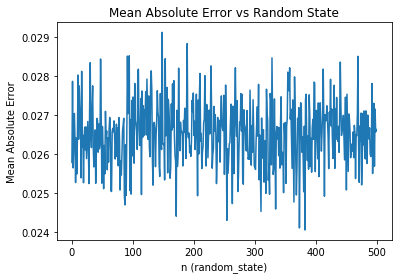

In [133]:
r_abs = np.array([[n[0]] for n in results])
plt.plot([[n] for n in range(500)],r_abs)
plt.xlabel("n (random_state)")
plt.ylabel("Mean Absolute Error")
plt.title("Mean Absolute Error vs Random State")

Text(0.5, 1.0, 'Mean Squared Error vs Random State')

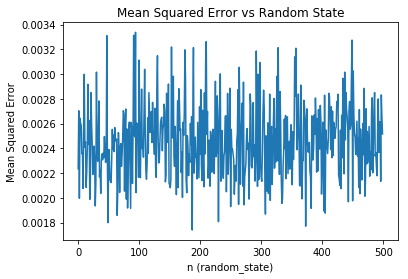

In [134]:
r_sqrt= np.array([[n[1]] for n in results])
plt.plot([[n] for n in range(500)],r_sqrt)
plt.xlabel("n (random_state)")
plt.ylabel("Mean Squared Error")
plt.title("Mean Squared Error vs Random State")

<font size="3">&emsp;&emsp;Random_state oferece melhores resultados nos 2 erros com valor aproximado de 370 a 390. O valor encontrado foi random_state=382. Vamos agora fazer o mesmo com n_estimators, fixando o random_state.</font><br><br>

In [ ]:
results = []
progress = 0.0
for n in range(1,401,7):
    rf_reg = ensemble.RandomForestRegressor(n_estimators=n, random_state=382).fit(train_X,train_Y)
    rf_pred = rf_reg.predict(test_X)
    # Mean Absolute Error
    abs_error = metrics.mean_absolute_error(rf_pred,test_Y)
    # Mean Squared Error
    sqrt_error = metrics.mean_squared_error(rf_pred,test_Y)
    results.append([abs_error, sqrt_error])
    progress += 1.0/58.0
    print(f'{progress*100}%', end='\r')

Text(0.5, 1.0, 'Mean Absolute Error vs Number of Estimators')

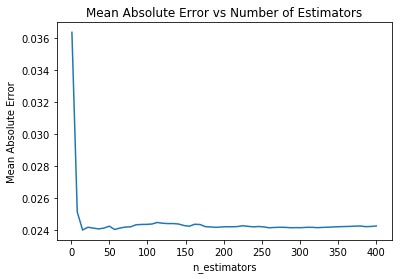

In [151]:
r_abs = np.array([[n[0]] for n in results])
plt.plot([[n] for n in range(1,401,7)],r_abs)
plt.xlabel("n_estimators")
plt.ylabel("Mean Absolute Error")
plt.title("Mean Absolute Error vs Number of Estimators")

Text(0.5, 1.0, 'Mean Squared Error vs Number of Estimators')

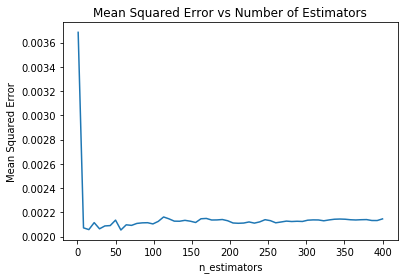

In [152]:
r_sqrt= np.array([[n[1]] for n in results])
plt.plot([[n] for n in range(1,401,7)],r_sqrt)
plt.xlabel("n_estimators")
plt.ylabel("Mean Squared Error")
plt.title("Mean Squared Error vs Number of Estimators")

<font size="3">&emsp;&emsp;N_estimators oferece melhor resultado com valor aproximado entre 1 e 36, dado que os testes foram feitos de 7 em 7 devido à limitação de processamento, tomando como base o erro médio absoluto. O valor escolhido foi n_estimators=15. Vamos agora testar com alguns valores de max_depth.</font><br><br>

In [ ]:
results = []
progress = 0.0
for n in range(1,33):
    rf_reg = ensemble.RandomForestRegressor(n_estimators=15, random_state=382, max_depth=n).fit(train_X,train_Y)
    rf_pred = rf_reg.predict(test_X)
    # Mean Absolute Error
    abs_error = metrics.mean_absolute_error(rf_pred,test_Y)
    # Mean Squared Error
    sqrt_error = metrics.mean_squared_error(rf_pred,test_Y)
    results.append([abs_error, sqrt_error])
    progress += 1.0/32.0
    print(f'{(progress*100):.2f}%', end='\r')

Text(0.5, 1.0, 'Mean Absolute Error vs Max Depth')

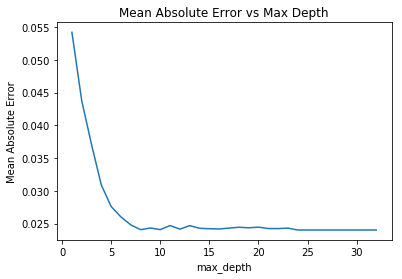

In [165]:
r_abs = np.array([[n[0]] for n in results])
plt.plot([[n] for n in range(1,33)],r_abs)
plt.xlabel("max_depth")
plt.ylabel("Mean Absolute Error")
plt.title("Mean Absolute Error vs Max Depth")

Text(0.5, 1.0, 'Mean Squared Error vs Max Depth')

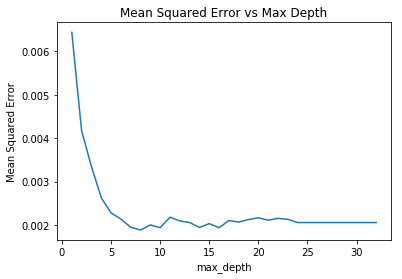

In [166]:
r_sqrt= np.array([[n[1]] for n in results])
plt.plot([[n] for n in range(1,33)],r_sqrt)
plt.xlabel("max_depth")
plt.ylabel("Mean Squared Error")
plt.title("Mean Squared Error vs Max Depth")

<font size="3">&emsp;&emsp;Max_depth foi testado com valores até 40% do número de atributos, por garantia para a possibilidade de *overfitting* diminuir ainda mais. O valor ideal encontrado foi max_depth = 22, com resultado aproximado de *Mean Absolute Error* = 0.0240231 e *Mean Squared Error* = 0.00205843, ainda melhor que o *Linear Regression*.</font><br><br>

## Clusterização

In [170]:
#load dataframe
premier_filename = 'premier_league/epl_1819.csv'
premier_dataframe = pd.read_csv(premier_filename)
premier_dataframe.head()

,Team,category,general_league_position,finance _live_games_televised,finance _tv_revenue,general_matches_played,general_won,general_draw,general_lost,attack_scored,...,defence_saves,defence_blocks,defence_interceptions,defence_tackles,defence_tackles_last_man,defence_clearances,defence_clearances_headed,defence_penalty_conceeded,attack_posession,attack_pass_accuracy
0,Manchester City,Champions League,1,26,150986355,38,32,2,4,95,...,58,63,362,518,0,543,295,4,64.0,89.0
1,Liverpool,Champions League,2,29,152425146,38,30,7,1,89,...,76,78,314,610,2,639,317,1,58.8,84.4
2,Chelsea,Champions League Qualification,3,25,146030216,38,21,9,8,63,...,85,73,351,618,2,593,330,2,59.9,87.6
3,Tottenham,Champions League Qualification,4,26,145230801,38,23,2,13,67,...,121,112,326,626,3,770,411,5,56.7,83.2
4,Arsenal,Europa League,5,25,142193180,38,21,7,10,73,...,133,118,412,609,2,762,404,7,56.1,83.3


### Preprocessing

In [171]:
# Drop Team
premier_dataframe.drop(columns=["Team"], inplace=True)

# replace nominal
premier_dataframe.category.replace({'Champions League': 0, 'Champions League Qualification': 1,
       'Europa League': 2, 'Europa League Qualification': 3,
       'No UEFA Competitions': 4, 'Relegated': 5}, inplace=True)

In [172]:
# Turning all attributes into numbers
for elem in premier_dataframe.columns:
    if premier_dataframe[elem].dtype == 'O':
        for each_member in premier_dataframe[elem]:
            premier_dataframe[elem].replace(each_member, each_member.replace(',',''), inplace=True)

premier_dataframe[premier_dataframe.select_dtypes("object").columns] = premier_dataframe[premier_dataframe.select_dtypes("object").columns].astype('int', inplace=True)

### Models

In [173]:
x = premier_dataframe.to_numpy()

In [174]:
def print_labels(labels):
    for each_key in labels:
        print( f'{each_key}: {labels[each_key]}' )

#### K-Means

In [175]:
labels_k = {2: [], 5: [], 10: []}
for each_case in [2,5,10]:
    km = cluster.KMeans(n_clusters=each_case, random_state=0).fit(x)
    labels_k[each_case] = km.labels_
print_labels(labels_k)

2: [1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
5: [3 1 1 1 1 2 4 4 4 0 0 0 0 0 0 0 0 0 0 0]
10: [3 9 1 7 7 2 5 6 6 0 0 0 0 0 4 4 4 4 8 8]


#### AgglomerativeClustering (Hierarchical)

In [176]:
labels_a = {2: [], 5: [], 10: []}
for each_case in [2,5,10]:
    ag = cluster.AgglomerativeClustering(n_clusters=each_case).fit(x)
    labels_a[each_case] = ag.labels_
print_labels(labels_a)

2: [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
5: [2 1 1 1 1 4 3 3 3 0 0 0 0 0 0 0 0 0 0 0]
10: [5 9 6 2 2 4 8 7 7 0 0 0 0 0 1 1 1 1 3 3]


<font size="3">Comparando os primeiros resultados:</font><br><br>

In [177]:
for each_key in labels_k:
    labels_k[each_key] = labels_k[each_key].reshape(-1,1)
    labels_a[each_key] = labels_a[each_key].reshape(-1,1)
results = labels_k[2]
results = np.append(results,labels_a[2], axis=1)
results = np.append(results,labels_k[5], axis=1)
results = np.append(results,labels_a[5], axis=1)
results = np.append(results,labels_k[10], axis=1)
results = np.append(results,labels_a[10], axis=1)
results = pd.DataFrame( results, columns=['K-Means 2','Agglomerative 2','K-Means 5','Agglomerative 5','K-Means 10','Agglomerative 10'] )
results

,K-Means 2,Agglomerative 2,K-Means 5,Agglomerative 5,K-Means 10,Agglomerative 10
0,1,0,3,2,3,5
1,1,0,1,1,9,9
2,1,0,1,1,1,6
3,1,0,1,1,7,2
4,1,0,1,1,7,2
5,1,0,2,4,2,4
6,0,1,4,3,5,8
7,0,1,4,3,6,7
8,0,1,4,3,6,7
9,0,1,0,0,0,0


<font size="3">&emsp;&emsp;Independente do valor de n_clusters, os algoritmos obtiveram os mesmos resultados. Os *labels* dos clusters não são os mesmos, mas são correspondentes, sendo os elementos agrupados da mesma forma. Vamos então fixar um número de clusters e alterar os parâmetros em cada algoritmo.</font><br><br>

#### K-Means

In [178]:
labels_k = { 1: np.zeros((20,1)), 10: np.zeros((20,1)), 100: np.zeros((20,1)) }
for each_case in [1,10,100]:
    km = cluster.KMeans(n_clusters=5, random_state=0, max_iter=each_case).fit(x)
    labels_k[each_case] = km.labels_.reshape(-1,1)

In [179]:
results = np.append(labels_k[1], np.append(labels_k[10], labels_k[100], axis=1), axis=1)
results = pd.DataFrame(results, columns=labels_k.keys())

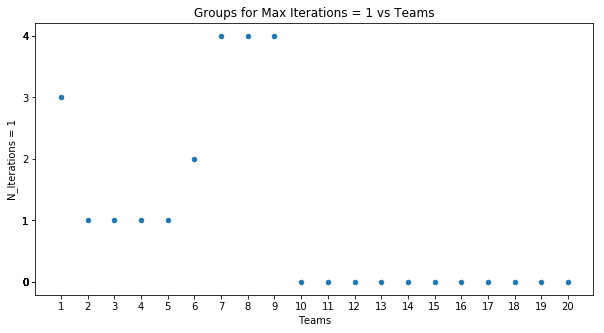

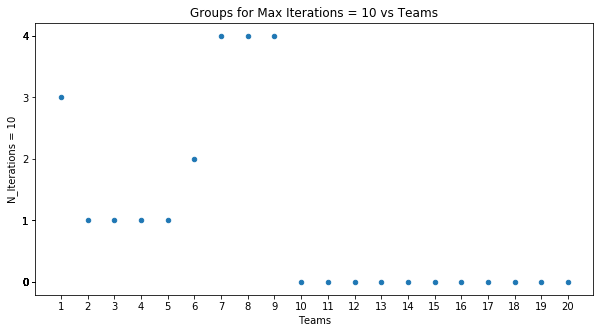

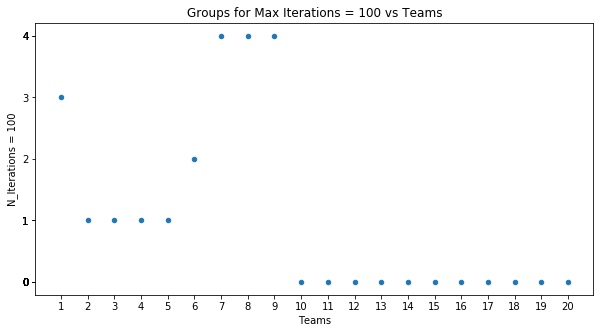

In [180]:
df = np.array([x for x in range(1,21)]).reshape(-20,1)
df = np.append(results.to_numpy(), df, axis=1)
df = pd.DataFrame(df, columns=['N_Iterations = 1', 'N_Iterations = 10', 'N_Iterations = 100', 'Teams'])

# Max_iterations = 1
df.plot.scatter(x='Teams',y='N_Iterations = 1',figsize=(10,5), title='Groups for Max Iterations = 1 vs Teams')
rand_var = plt.xticks(df['Teams'])
rand_var = plt.yticks(df['N_Iterations = 1'])

# Max_iterations = 10
df.plot.scatter(x='Teams',y='N_Iterations = 10',figsize=(10,5), title='Groups for Max Iterations = 10 vs Teams')
rand_var = plt.xticks(df['Teams'])
rand_var = plt.yticks(df['N_Iterations = 10'])

# Max_iterations = 100
df.plot.scatter(x='Teams',y='N_Iterations = 100',figsize=(10,5), title='Groups for Max Iterations = 100 vs Teams')
rand_var = plt.xticks(df['Teams'])
rand_var = plt.yticks(df['N_Iterations = 100'])

<font size="3">&emsp;&emsp;Independente do número de iterações, os grupos continuam os mesmos, com os mesmos *labels*. Vamos normalizar os dados e comparar os resultados.</font><br><br>

#### Normalization

In [181]:
normalized_premier_dataframe = normalize_df(premier_dataframe)

In [182]:
x = normalized_premier_dataframe.to_numpy()

labels_k_norm = { 1: np.zeros((20,1)), 10: np.zeros((20,1)), 100: np.zeros((20,1)) }
for each_case in [1,10,100]:
    km = cluster.KMeans(n_clusters=5, random_state=0, max_iter=each_case).fit(x)
    labels_k_norm[each_case] = km.labels_.reshape(-1,1)

In [183]:
results_norm = np.append(labels_k_norm[1], np.append(labels_k_norm[10], labels_k_norm[100], axis=1), axis=1)
results_norm = pd.DataFrame(results_norm, columns=labels_k_norm.keys())

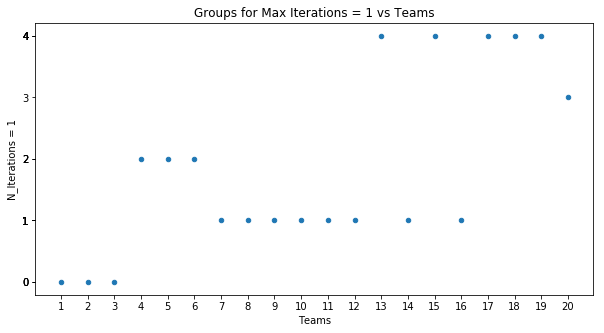

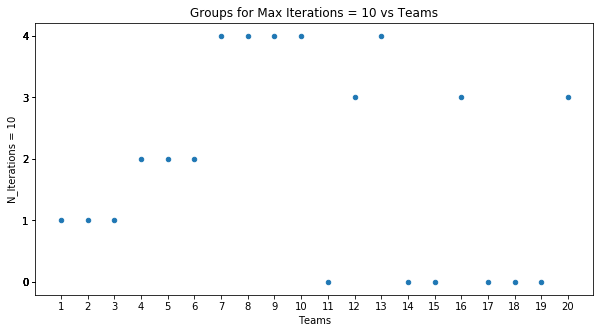

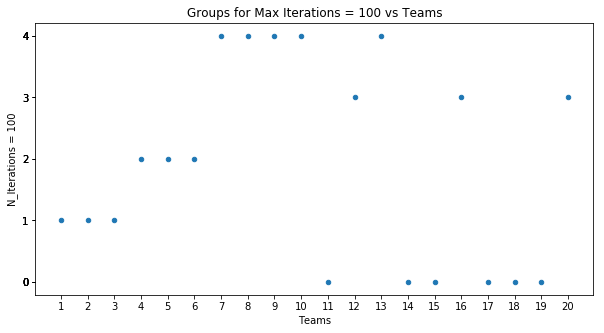

In [184]:
norm_df = np.array([x for x in range(1,21)]).reshape(-20,1)
norm_df = np.append(results_norm.to_numpy(), norm_df, axis=1)
norm_df = pd.DataFrame(norm_df, columns=['N_Iterations = 1', 'N_Iterations = 10', 'N_Iterations = 100', 'Teams'])

# Max_iterations = 1
norm_df.plot.scatter(x='Teams',y='N_Iterations = 1',figsize=(10,5), title='Groups for Max Iterations = 1 vs Teams')
rand_var = plt.xticks(norm_df['Teams'])
rand_var = plt.yticks(norm_df['N_Iterations = 1'])

# Max_iterations = 10
norm_df.plot.scatter(x='Teams',y='N_Iterations = 10',figsize=(10,5), title='Groups for Max Iterations = 10 vs Teams')
rand_var = plt.xticks(norm_df['Teams'])
rand_var = plt.yticks(norm_df['N_Iterations = 10'])

# Max_iterations = 100
norm_df.plot.scatter(x='Teams',y='N_Iterations = 100',figsize=(10,5), title='Groups for Max Iterations = 100 vs Teams')
rand_var = plt.xticks(norm_df['Teams'])
rand_var = plt.yticks(norm_df['N_Iterations = 100'])

In [213]:
def plot_results(df, n_df, key, x_label, y_label):
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(111,xlabel=x_label, ylabel=y_label)
    ax1.scatter(df['Teams'],df[key],c='r',marker="s", label='Actual Values')
    ax1.scatter(n_df['Teams'],n_df[key],c='g',marker="o", label='Normalized Values')
    plt.legend(loc='best');
    rand_var = plt.xticks(n_df['Teams'])
    rand_var = plt.yticks(n_df[key])
    plt.title(f"{key} vs Teams")

    plt.show()

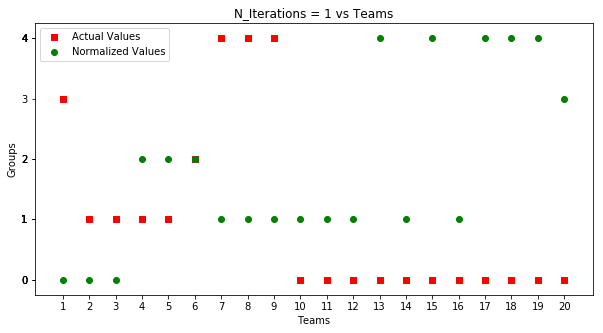

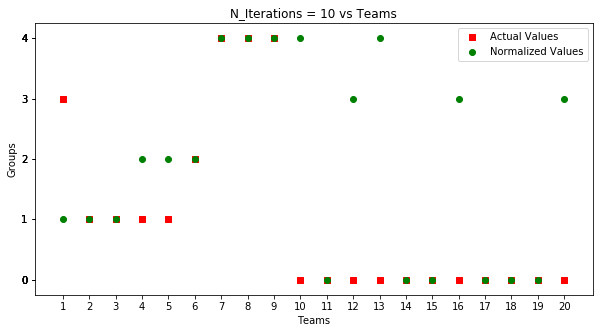

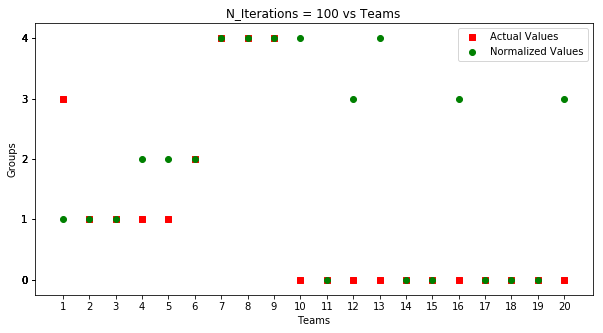

In [216]:
# Comparing results
plot_results(df, norm_df, 'N_Iterations = 1', 'Teams', 'Groups')
plot_results(df, norm_df, 'N_Iterations = 10', 'Teams', 'Groups')
plot_results(df, norm_df, 'N_Iterations = 100', 'Teams', 'Groups')

#### AgglomerativeClustering (Hierarchical)

In [131]:
labels_a = {"ward": np.zeros((20,1)), "complete": np.zeros((20,1)), "average": np.zeros((20,1)), "single": np.zeros((20,1))}
for each_case in ["ward", "complete", "average", "single"]:
    ag = cluster.AgglomerativeClustering(n_clusters=5, linkage=each_case).fit(x)
    labels_a[each_case] = ag.labels_.reshape(-1,1)

In [132]:
results = np.append(labels_a["ward"], np.append(labels_a["complete"], np.append(labels_a["average"], labels_a["single"], axis=1), axis=1), axis=1)
results = pd.DataFrame(results, columns=labels_a.keys())
results

,ward,complete,average,single
0,2,3,2,2
1,1,1,1,0
2,1,1,1,0
3,1,1,1,0
4,1,1,1,0
5,4,4,3,3
6,3,2,4,4
7,3,2,4,1
8,3,2,4,1
9,0,0,0,1


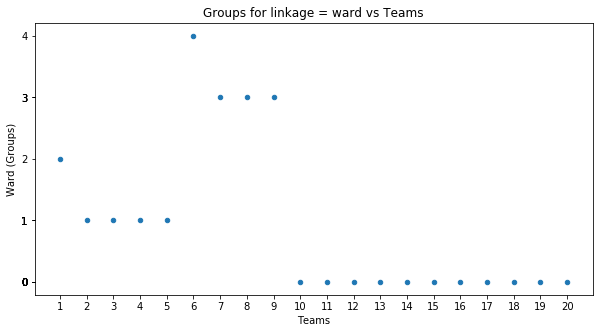

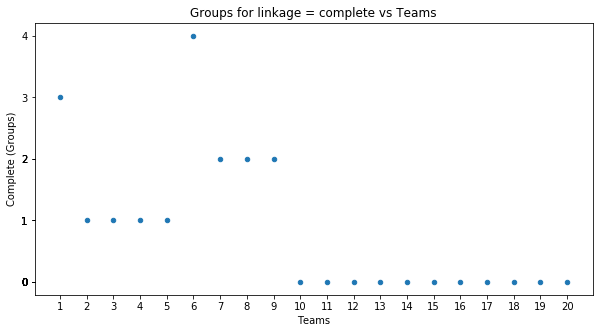

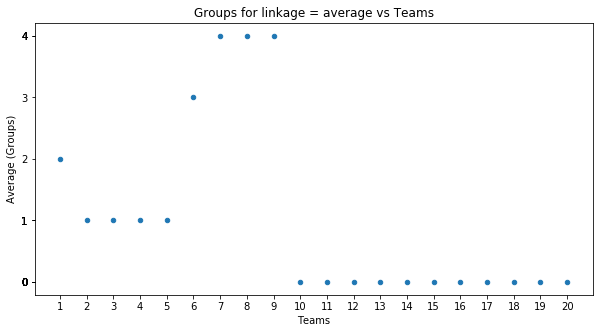

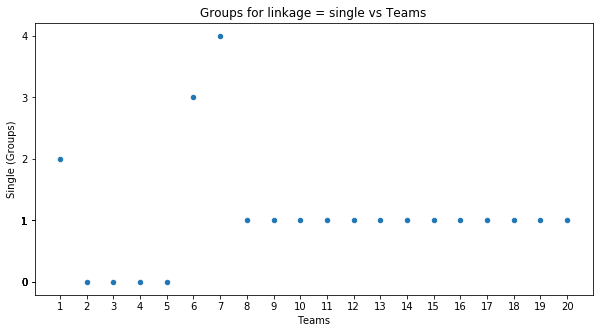

In [133]:
df = np.array([x for x in range(1,21)]).reshape(-20,1)
df = np.append(results.to_numpy(), df, axis=1)
df = pd.DataFrame(df, columns=['Ward (Groups)', 'Complete (Groups)', 'Average (Groups)', 'Single (Groups)', 'Teams'])

# Linkage = ward
df.plot.scatter(x='Teams',y='Ward (Groups)',figsize=(10,5), title='Groups for linkage = ward vs Teams')
rand_var = plt.xticks(df['Teams'])
rand_var = plt.yticks(df['Ward (Groups)'])

# Linkage = complete
df.plot.scatter(x='Teams',y='Complete (Groups)',figsize=(10,5), title='Groups for linkage = complete vs Teams')
rand_var = plt.xticks(df['Teams'])
rand_var = plt.yticks(df['Complete (Groups)'])

# Linkage = average
df.plot.scatter(x='Teams',y='Average (Groups)',figsize=(10,5), title='Groups for linkage = average vs Teams')
rand_var = plt.xticks(df['Teams'])
rand_var = plt.yticks(df['Average (Groups)'])

# Linkage = single
df.plot.scatter(x='Teams',y='Single (Groups)',figsize=(10,5), title='Groups for linkage = single vs Teams')
rand_var = plt.xticks(df['Teams'])
rand_var = plt.yticks(df['Single (Groups)'])

<font size="3">&emsp;&emsp;Comment</font><br><br>